**Abstract** 

This note and Julia notebook presents a simulation-based method and associated Julia 
software package for estimating covid-19 infection risks.  

Our approach differs from many covid-19 simulations, in that it is *small-scale*: it doesn't try to model an entire population, but only a few individuals (from one to perhaps two dozen).  The primary 
goal is to estimate the probability that each individual is infected, based on a history of their recent 
contacts and test results (as well as certain assumptions and other information).

A simulation consists of many *simulation runs*; we also call a simulation
run a *scenario* or a *world*.  Each simulation run is based on the provided history
of contacts and test results, but may vary in the pattern of how infection starts and spreads among the individuals.
Simulation runs that give results inconsistent with provided test results are discarded.  The probability
that an individual is infected at the end is estimated as the fraction of remaining simulation runs in which
that individual is infected.

A simulation may also take into account:
* whether individuals are wearing **masks** (and if so, what type of mask)
* the **duration** of contacts (disease transmission is modeled in a **dose-based** manner)
* **multi-person contacts** (e.g. for a dinner)
* the presence of one or more **anonymous individuals** in a multi-person contact (e.g. bus riders)
* given probabilities for the prevalence of the disease in the population, and the likelihood
  of mask-wearing in the population, both used to model anonymous individuals
* different **types of tests** with differing probabilities for detection and false alarms
* many infected individuals are **asymptomatic**
* infected individuals progress through a series of stages of the disease,
* the **infectiousness** of an infected individual may vary over time,
* infected individuals typically recover after a certain time (e.g. 14 days)
* an infected individual, if symptomatic, has symptom onset around a certain time
  since infection (e.g. on the 5th day).

<!--- <img src="images/foo3.jpg" width=300> --->

# Approach

Our approach is [*agent-based*](https://en.wikipedia.org/wiki/Agent-based_model);
each individual is separately modeled in the simulation.

In our agent-based model each individual
may have a complex state consisting of a number of attributes. 
We consider attributes to be of two types: the ``disease state'' of the agent 
(e.g. Susceptible, Infected, or Recovered), 
and other "observable state" attributes (e.g. whether the individual is masked).  

The disease state is not directly observable, but may be measured with a 
Test (which will give a result of positive -- meaning infected -- or negative -- meaning uninfected).  
In our model we further subdivide the
Infected state into a sequence of states I1, I2, ..., ILast (e.g. I14)
according to the number of days the individual has been infected.

As a pedagogic digression, we note that 
an interesting class of agent-based models are the "billiard-ball models",
as exemplified in this
[Washington Post article](https://www.washingtonpost.com/graphics/2020/world/corona-simulator/).
Each billiard ball represents a person, and the color of the ball represents the
disease state of that person (healthy, sick, recovered).  The billiard ball's position
and velocity are also part of the state information for the person modelled.  Collisions between balls represent contact events where an infected person may infect an uninfected person.

Each time you reload the Washington Post page, it starts a new simulation run, where
the positions, velocities, and initial disease states of the balls are freshly and randomly generated;
a new run may thus give somewhat different results.
Performing many such simulation runs allows one to estimate statistics such as the
fraction of individuals infected after a certain amount of time has elapsed.

We adopt a similarf approach, but restrict the rerandomization to 
the initial disease states and
the test results obtained.

Our approach is not compartmental; a compartmental model keeps only aggregate estimates about the number of individuals in each compartment, and a set of differential equations determines how these estimates evolve over time. An SIR model is a typical example of a compartmental model, wherein the model state consists only of the estimated number of Susceptible ("S"), Infectious ("I"), and Recovered ("R") individuals.

## Fixed versus stochastic contact schedules

We now elaborate and clarify this distinction between agent-based models with fixed contact schedules and agent-based models with variable or stochastic contact schedules, as this distinction is not often made or adopted in the simulation literature.

*We restrict attention to agent-based models where the sequence of contacts made is fixed and independent of the spread of the disease*.

If we consider a given simulation run, we see a sequence of *contact events*, such as:
* on day 1, person A has a close contact with person B,
* on day 2, person A has a close contact with person C,
* on day 3, person B has a close contact with person C, then
* on day 3, person A, B, and C have a three-way close contact
* and so on...
(We use the phrases "has a contact with" and "has a close contact with" 
interchangeably to denote a contact where disease transmission is possible.)

In a "billiard ball" model, the sequence of contacts is determined by the initial positions and velocities of the balls, but *not* by any other information, such as the disease states of the individuals.  The schedule of contacts is fixed by the initial
position and velocities.

An individual may become infected during a contact, but he/she thereafter continues life as usual.  This is appropriate for a disease that is entirely asymptomatic, and is an interesting and useful restriction to adopt for disease in general.

We therefore adopt the restriction that
the model has a **fixed contact schedule**:
*the model has a fixed schedule of contacts that is used for 
any simulation run*. 

Even if the model has a fixed contact schedule, the spread of the disease among the
simulated individuals in that model may vary stochastically from simulation run to simulation run, 
since the spread of the disease also depends on other factors, such as:
* who is infected at the beginning of the simulation run (the initial conditions)
* the stochastic character of disease transmission during a contact (that is, if
  A and B have a contact, and A is infected but B is not, whether A infects B may
  happen only randomly with some probability)
* whether the simulated individuals are wearing mask (and if so, what sort of mask), 
  which may decrease the disease transmission probability for a contact,
and so on...

## Motivation

The reason we are interested in agent-based models having a fixed contact schedule 
is that *we are interested in real-life situations where the contact history may in fact be known*, and we wish to estimate the probability that an individual is infected in such situations.

For example, the contact history may be known because of smartphone-based (or wearable-token-based) digital contact tracing.  It may be known exactly who was in contact with whom for the last two weeks, among the entire population.  

(The previous paragraph sets aside the fact that collecting such information may be undesirable for privacy reasons.  So, the exercise here is to explore what might be 
possible if one were to collect such information.  But this work should in no way be 
interpreted as saying that the privacy concerns aren't important, or that they shouldn't
prevail if one is considering the possibility of such data collection.)

Of course, it is not required that the contact schedule be known and/or derived from
real-life data.  It can be pseudorandomly generated, for example.  Or, it may be a mix
of real-life contact data and pseudorandomly generated data.

The intent, however, is that the contact schedule be the historical schedule of real people,
rather than simulated people.  We would like to know how likely it is that a specific 
real person is infected, so we can advise on a course of action to take (e.g. quarantining).

This work may inform decisions at the micro level 
as to whether an individual should quarantine, whether
a pod is ``good to go``, or the like.

This work is _not_ intended to inform policy decisions at the macro level, as to
what non-pharmaceutical interventions should be recommended, say.  It does not address
any issues relating to contact tracing or exposure notification.


## Graphical representation

We now introduce the graphical representation of a schedule.  This consists of the following
components and semantics:
* a two-dimensional canvas to hold the graphical elements
* the vertical axis represents time, with time increasing from top to bottom (measured in days).
* the canvas is divided into blocks representing days by horizontal dotted lines
* each named person in the schedule is represented by a solid vertical line (or *wire*)
* each wire carries information from top to bottom about the state of the individual, such as
  whether they are infected or not, or whether they are masked
* there are several kinds of events possible in the schedule:
  - ***NewPerson*** events, which introduces a new **named** person, and
    representing that for each simulation run the individual's disease state may be simulated 
    via a random draw from a specified distribution.  Typically, just the overall prevalence is
    specified, and the distribution is uniform over I1..ILast.
  - ***Contact*** events representing the possibility of transmission of disease between individuals.
    Each contact event represents a close contact when an uninfected party may become infected, if 
    another party is infected.  The transmission probability of the disease depends on the duration of
    the contact and on whether the parties are
    wearing masks.  Transmission may go either way between two parties.  If the
    number n of parties is greater than two, than the event is equivalent to having choose(n, 2) 
    pairwise contacts (that is, having a contact between each pair of people at the event).  A person
    infected at an event can not infect another person at the same event (but can infect someone else
    at a later event that day).  A number of parties to the contact event may be *anonymous*.
  - ***Test*** events, representing the person getting a test, represented by a square
    containing "Test" (with the result given in the rightmost column).
    Simulation runs are counted only if they are *consistent* with the specified test results.
    We assume that the test result is available immediately.
  - ***Mask-setting*** events: the individual takes off or puts on a mask, represented
    by a square with either "MaskOn" or "MaskOff".
  - ***NewDay*** events representing the start of a new day.  Some of the participants will recover
    in this transition.
  - ***Stats*** event representing the gathering of statistics -- the fraction of consistent runs wherein
    each named person is infected.

## Example schedule

Consider the following example schedule

![SimRiskExample.png](SimRiskExample.png)

This example shows a contact schedule for three named individuals (me, Jack and Jill) over a period
of two days.  There are eleven events.

The following code specifies the model to be simulated:
```
function example9()::Model
    m = Model("Example 9")
    # day 1
    notePerson!(m, "me", infectedProbability=0.00, maskedProbability=0.500)
    notePerson!(m, "Jack", infectedProbability=0.05, maskedProbability=0.000)
    notePerson!(m, "Jill", infectedProbability=0.10, maskedProbability=1.00)
    noteStats!(m)
    noteContact!(m, ["me", "Jack"], minutes=120)
    noteContact!(m, ["me", "Jill"], anonymousNumber=4, minutes=60)
    # day 2
    noteNewDay!(m)
    noteStats!(m)
    noteTest!(m, "Jack", PCRTest, true)
    noteTest!(m, "Jill", PCRTest, false)
    noteStats!(m)
    return m
end    
```

* The first three `notePerson!` events specify the three named individuals in the model.

  - The first named person, `me`, starts every simulation run uninfected.  I wear a mask half of the time.
    (This means that I start off masked in half of the simulation runs.)
  - The second named person, `Jack`, starts off each simulation run with a 5% chance of being infected.
    Jack never wears a mask.
  - The third named person, `Jill`, starts off each simulation run with a 10% chance of being infected.
    Jill always wears an N95 mask with 95% filtration ability when Jill is the "sender" or when Jill is
    the "receiver".

* The first `Stats` event gathers statistics, showing the initial 0% / 5% / 10% infection rates 
  for me, Jack, and Jill.
  These are computed using 100000 simulation runs, and show the number of such runs wherein each party is
  infected.
* The next two events on day 1 are contact events:
  - Jack and I have a two-hour meeting.
  - Jill and I, together with four anonymous other individuals, have a one-hour lunch.
* The next event is the beginning of day two.  In some simulation runs, some individuals
  recover in this transition (about 1/14 of them will do so).
* The next event is a `Stats` event, showing that me, Jack, and Jill have infection probabilities
  of 1% / 5% / 9%.  (Remember that Jill always wears a mask!)
  These percentages are percentages of the 100000 simulation runs wherein each party is infected.
* The next two events are `Test` events:
  - a PCR `Test` event for Jack; it shows him to be infected.  This PCR test has a
    5% false-positive and a 5% false-negative rate.
  - a similar PCR `Test` event for Jill, it shows her to be uninfected.
* The final event is a `Stats` showing me, Jack, and Jill to be infected with respective
  probabilities 8%, 49%, and 1%.
  Note that only 8074 simulation runs showed Jack testing positive and Jill testing negative;
  the other simulation runs are discarded at this point.
  The percentages given are the percentages of the 8074 simulation runs that gave results for the
  two Test events that were consistent with the observed Test results, that showed each of
  the three named individuals being infected.

In general, events may have
stochastic effects, which is why simulation is needed to determine the probability
that a named individual is infected at the end of the schedule.  A random number seed
and appropriate cryptographic for the simulation allow the use of pseudorandomness here, for reproducibility.

Note that the infection probabilities of anonymous individuals are not estimated;
each contact including anonymous individuals is assumed to include freshly-minted
anonymous individuals with infection probability equal to the overall prevalence rate
of infection.

This is clearly a simplistic model that could be made more realistic in a number of ways.

# Disease States

In [1]:
# We represent the following disease states:
#     Susceptible  I1 I2 ... ILast  Recovered
# We use ILast = I14 here.  Later versions may make "14" variable.
# These are "daily" states, giving the disease state at the end of the day.
# States I1 ... I14 are "infected" states; these states are not necessarily "infectious".
# An infected person progresses from state I1 to state Recovered, one state at a time per day.
# Moving from state Susceptible to state I1 is the initial infection.
# Moving from state I14 to state Recovered is "recovery".
# We represent these states as integers as follows:
# a state Id (where d is an integer) is the disease state at the end of the d-th day of infection.
# So, I1 is the end of the first day of infection, etc.
# We use the encoding of disease states as integers:
#    Susceptible = 0
#    I1 ... I14 = 1 ... 14
#    Recovered = 15

struct DiseaseState <: Integer
    ds::Int64
end
Int64(x::DiseaseState) = x.ds 
import Base.<
<(x::DiseaseState, y::DiseaseState) = (x.ds < y.ds)

# Although Julia uses 1-indexing, we start DiseaseState at 0 (= Susceptible);
# so arrays that are indexed by DiseaseState are 0-indexed
const Susceptible = DiseaseState(0)
const I1 = DiseaseState(1)           # when person is infected, they move to state I1
const ILast = DiseaseState(14)       # last infected disease state
const Recovered = DiseaseState(15)

DiseaseState() = Susceptible         # default starting disease state

infected(x::DiseaseState) = (Susceptible < x < Recovered)

SymptomOnset = DiseaseState(5)  # if symptomatic, symptoms start on day 5

# if state ds on day d, give state on next day
function nextDiseaseState(ds::DiseaseState)
    (ds == Susceptible) && return ds
    (ds == Recovered) && return ds
    return DiseaseState(Int(ds.ds)+1)
end

nextDiseaseState (generic function with 1 method)

In [2]:
# infectiousness as a function of DiseaseState
# average of infected states is 1.000
# using Pkg ;
# Pkg.add("OffsetArrays") ;
using OffsetArrays ;

defaultInfectiousness =      # improve this list?
    OffsetArray([0, 
                 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,  # note 0 for I1
                 0],
                0:15) * (14.0 / 18.0);

## Tests

When using a fixed contact schedule, we assume that
testing affects the *transmission probability* but not the *contact schedule* or
other observable attributes such as whether a person is wearing a mask.


In [3]:
struct TestType
    name::String         # name of test type
    P_det::Float64       # Probability of detecting infection 
                         #     = P(pos test result | infected)
                         #     = sensitivity
    P_FA::Float64           # Probability of a false alarm 
                         #     = P(pos test result | uninfected)
                         #     = 1 - specificity
end

PerfectTest = TestType("Perfect", 1.0, 0.0)       # this test is always right
PCRTest = TestType("PCR", 0.95, 0.05)             # check (if adjust here, also adjust examples)
OtherTest = TestType("Other", 0.90, 0.10)         # for comparison purposes, not a real test

TestType("Other", 0.9, 0.1)

## Masks

Same for masks; being masked affects transmission probability but not the event schedule.

A MaskType is defined by is filtration efficiencies (separately as source and as recipient).

In [4]:
struct MaskType
    sourceMaskTransmission::Float64    # 1 - filtrationEfficiency for source, if source wearing this mask type
    recipientMaskTransmission::Float64 # 1 - filtrationEfficiency for recipient, if recipient wearing this mask type
end

N95 = MaskType(0.05, 0.05)          # Check numbers
Surgical = MaskType(0.30, 0.20)     # Check numbers
NoMask = MaskType(1.00, 1.00)       

MaskType(1.0, 1.0)

## Quarantine
    
We do not explicitly model quarantining; we assume that the given events already
incorporate any effects that quarantining might have had.  

# People

Each person is represented in the simulation by a Person object.  We might also
call this a *node* or a *vertex*, using graph-theoretic terminology.

The node contains a number of attributes, which may change value as the
simulation progresses; the Person object is a *mutable* data structure.

In [5]:
struct VisibleState
    # represents state elements that are visible and may affect disease transmission
    mask::MaskType
end
# Default VisibleState is unmasked
VisibleState() = VisibleState(NoMask)

VisibleState

In [6]:
mutable struct Person # aka Agent

    # static attributes of person
    personID::String

    # per-run attributes of person
    asymptomatic::Bool                   # whether asymptomatic on this run
    
    # per-run dynamic attributes of person (changes over time)
    diseaseState::DiseaseState
    visibleState::VisibleState
end

# Key Additional Concepts

## Global parameters

One struct gives a list of global parameters, such as prevalence rate, in a timeless manner.

In [7]:
mutable struct GlobalParameters
    # parameters for random named people
    infectedProbability::Float64        # probability that a random person is infected
    maskedProbability::Float64          # probability that a random person is masked
    asymptomaticProbability::Float64    # probability that a random person is asymptomatic

    # same parameters for random anonymous people
    anonymousInfectedProbability::Float64
    anonymousMaskedProbability::Float64
    anonymousAsymptomaticProbability::Float64

    # ContactEvent parameters

    # A contact with a give dose (arbitrary units) between two maskless individuals 
    # has a probability of transmission of 1 - exp(-dose*transmissionConstant)
    transmissionConstant::Float64 
    asymptomaticFactor::Float64   # reduce dose by this factor if source is asymptomatic
    
    # infectiousness as a function of DiseaseState (indices will be -1:infectionDurationDays)
    infectiousness::OffsetArray{Float64,1,Array{Float64,1}}
end

# default parameters for named people
defaultInfectedProbability = 0.02      # prevalence in community
defaultMaskedProbability = 0.000
defaultAsymptomaticProbability = 0.40  # https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html

# same parameters for anonymous people
defaultAnonymousInfectedProbability = defaultInfectedProbability
defaultAnonymousMaskedProbability = defaultMaskedProbability
defaultAnonymousAsymptomaticProbability = defaultAsymptomaticProbability

# We choose the transmission constant so that 
# a fifteen-minute contact has a 5% chance of transmission.
defaultContactDuration = 15.0                 # 15 minutes in close contact
defaultContactTransmissionProbability = 0.05  # yields 5% chance of transmission
defaultTransmissionConstant = log(1-defaultContactTransmissionProbability)/ (-defaultContactDuration)
# following value is from 
#   https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
defaultAsymptomaticFactor = 0.75

defaultGlobalParameters = 
    GlobalParameters( defaultInfectedProbability,
                      defaultMaskedProbability,
                      defaultAsymptomaticProbability,
                      defaultAnonymousInfectedProbability,
                      defaultAnonymousMaskedProbability,
                      defaultAnonymousAsymptomaticProbability,
                      defaultTransmissionConstant,
                      defaultAsymptomaticFactor,
                      defaultInfectiousness
                    ) 

GlobalParameters(0.02, 0.0, 0.4, 0.02, 0.0, 0.4, 0.0034195529591700387, 0.75, [0.0, 0.0, 0.777778, 1.55556, 1.55556, 1.55556, 1.55556, 1.55556, 0.777778, 0.777778, 0.777778, 0.777778, 0.777778, 0.777778, 0.777778, 0.0])

# Events

Each event specifies how the model state is to be updated during a simulation run.
The update may be probabilistic.

For example, an event might say that if Bob is infected but Alice is not, 
then Alice becomes infected with probability 15%.

The effects of an event may depend on the attributes of the input nodes.  For example,
in our example transmission probability may be smaller if either Alice and Bob are wearing masks,
and smaller still if both are wearing masks.

Each event in effect runs some program, that takes as input a person or a set of
people, and updates the state of that person or those people.

In [8]:
struct DefaultParametersEvent      # set model default global parameters to these values
    infected::Float64
    masked::Float64
end

In [9]:
struct NewPersonEvent
    person::Person                 # person created first, then NewPersonEvent
    infectedProbability::Float64   # e.g. prevalance of infection in the population individual is drawn from
                                   # assume equally likely to be any of I1...ILast
                                   # Todo: update for other distributions.
    maskedProbability::Float64     # probability that new individual is masked
    asymptomaticProbability::Float64 # probability that new individual is asymptomatic
    
end

In [10]:
struct NewDayEvent
end    

In [11]:
# A Test Event is a measurement of the disease state of a person,
# together with a required (reported) value for that test result.
struct TestEvent
    person::Person
    testType::TestType
    reportedTestResult::Bool       # simulated test result must match this reportedTestRestult
                                   # or else simulation run doesn't count
end

In [12]:
struct SymptomOnsetEvent
    person::Person
    reportedSymptomOnsetResult::Bool  # true if symptoms start on this day
end

In [13]:
struct ContactEvent  # Close Contact Event between two or more people 
                     # An Int means that many people with default parameter settings
                     # (Vertical line segment joining two or more horizontal Person lines)
    minutes::Int 
    people::Vector{Person}
    anonymousNumber::Int64
    anonymousInfectedProbability::Float64
    anonymousMaskedProbability::Float64
    anonymousAsymptomaticProbability::Float64
end

In [14]:
struct MaskEvent           # cause individual to become masked (with given MaskType)
    person::Person
    mask::MaskType 
end

In [15]:
struct StatsEvent           # collect statistics: is each named person infected?
end

In [16]:
Event = Union{DefaultParametersEvent, NewPersonEvent, NewDayEvent, 
              TestEvent, SymptomOnsetEvent, ContactEvent, MaskEvent, StatsEvent}

Union{NewDayEvent, StatsEvent, DefaultParametersEvent, ContactEvent, MaskEvent, NewPersonEvent, SymptomOnsetEvent, TestEvent}

# Models

The model contains 
* global parameters, 
* a list of all named people in the model, 
* an (ordered) *event list* of *events*
  (The event list is a *schedule* of events to be run by the scheduler; 
  the events happen in the specified order), and
* the number of StatsEvent entries in the event list

In [17]:
mutable struct Model
    params::GlobalParameters
    people::Vector{Person}    # all people in model
    events::Vector{Event}     # all events in model, ordered by time of occurrence
    name::String              # name of the model
    nStats::Int64             # number of stats events in event list
    stats::Dict               # statistics gathered
end
Model() = Model(defaultGlobalParameters, [], [], "", 1, Dict())
Model(name::String) = Model(defaultGlobalParameters, [], [], name, 1, Dict())

Model

## Model initialization and specification

This section gives the tools for specifying a model.

The model must be completely specified before simulation can begin.

The model-specification API consists of number of functions, each of whose
name begins with ``note``, and take as their first argument the model being
specified.

Some of the main model-specification functions are:

* **``notePerson!``** introduces a new named person into the model.
  ```
  notePerson!(m, 
              personID,
              infectedProbability,
              maskedProbability,
              asymptomaticProbability)
  ```   
  
* **``noteContact!``** specifies a contact between two or more people.  At least one
  of them should be named.  A number of anonymous individuals may be included in the contact.
  ```
  noteContact!(m,
               personIDs;
               minutes,
               anonymousNumber,
               anonymousInfectedProbability,
               anonymousMaskedProbability,
               anonymousAsymptomaticProbability)
  ```  
* **``noteTest!``** specifies a test given to a named person, and the result.
  ```
  noteTest!(m,
            personID,
            testType,
            reportedTestResult::Bool)
  ```
* **``noteStats!``** requests a printout or display of the infection probabilities of all
  named people.
  ```
  noteStats!(m)
  ```
* Others include
  - ``noteNewDay!``
  - ``noteSymptomOnset!``
  - ``noteMaskEvent!``
                 

In [18]:
function noteDefaultParameters!(m::Model, infectedProbability::Real, maskedProbabilty::Real)
    e = DefaultParametersEvent(infectedProbability, maskedProbability)
    push!(m.events, e)
end

noteDefaultParameters! (generic function with 1 method)

In [19]:
function findPersonByID(m, personID)::Person
    for p in m.people
        if p.personID == personID
            return p
        end
    end
    error("No person is known having ID: " * personID)
end

findPersonByID (generic function with 1 method)

In [20]:
function notePerson!(m::Model, 
                     personID; 
                     infectedProbability::Float64 = m.params.infectedProbability,
                     maskedProbability::Float64 = m.params.maskedProbability,
                     asymptomaticProbability::Float64 = m.params.asymptomaticProbability)
    p = Person(personID, false, DiseaseState(), VisibleState())
    e = NewPersonEvent(p, infectedProbability, maskedProbability, asymptomaticProbability)
    push!(m.people, p)
    push!(m.events, e)
end

notePerson! (generic function with 1 method)

In [21]:
function noteNewDay!(m::Model)
    push!(m.events, NewDayEvent())
end

noteNewDay! (generic function with 1 method)

In [22]:
function noteTest!(m::Model, 
                   personID::String,
                   testType::TestType,
                   reportedTestResult::Bool)
    person = findPersonByID(m, personID)
    push!(m.events, TestEvent(person, testType, reportedTestResult))
end

noteTest! (generic function with 1 method)

In [23]:
function noteSymptomOnset!(m::Model,
                           personID::String,
                           reportedSymptomOnsetResult)
    person = findPersonByID(m, personID)
    push!(m.events, SymptomOnsetEvent(person, reportedSymptomOnsetResult))
end

noteSymptomOnset! (generic function with 1 method)

In [24]:
function noteContact!(m::Model, 
                      personIDs;
                      minutes::Int64 = 15,
                      anonymousNumber::Int64 = 0,
                      anonymousInfectedProbability::Float64 = m.params.anonymousInfectedProbability,
                      anonymousMaskedProbability::Float64 = m.params.anonymousMaskedProbability,
                      anonymousAsymptomaticProbability::Float64 = m.params.anonymousAsymptomaticProbability)
    # here a "personID" should be a String
    # Strings are looked up (converted to existing people); 
    people = []
    for personID in personIDs
        push!(people, findPersonByID(m, personID))
    end
    e = ContactEvent(minutes, 
                     people, 
                     anonymousNumber, 
                     anonymousInfectedProbability,
                     anonymousMaskedProbability,
                     anonymousAsymptomaticProbability)
    push!(m.events, e)
end

noteContact! (generic function with 1 method)

In [25]:
function noteMaskEvent(m::Model, personID::String, mask::MaskType)
    p = findPersonByID(m, personID)
    push!(m.events, MaskEvent(m, p, mask))
end

noteMaskEvent (generic function with 1 method)

In [26]:
function noteStats!(m::Model)
    push!(m.events, StatsEvent())
end

noteStats! (generic function with 1 method)

# Simulation

## Random number generation

In [27]:
using NBInclude   # Use custom routines for generating random numbers, for reproducibility.
@nbinclude("SimRiskRandom.ipynb")

function withProbability(seed::UInt, index::Int, probability::Real)::Bool
    return (SimRiskRandom.myRand(seed, index) < probability)
end

function fromRange(seed::UInt, index::Int, range::UnitRange)
    return SimRiskRandom.myRand(seed, index, range)
end

function subSeed(seed::UInt, index::Int)::UInt
    return SimRiskRandom.myKDF(seed, index)
end

subSeed (generic function with 1 method)

## Statistics

In [28]:
using Formatting

function initStats!(m::Model)
    return m.stats = Dict()    # mapping from (person, day) pairs to run counts
end

function gatherStats!(m::Model, t::Int)
    stats = m.stats
    for p in m.people
        stats[(p,t,"infected runs")] = get(stats, (p,t,"infected runs"), 0.0) + 
                              infected(p.diseaseState)
        stats[(p,t,"total runs")] = get(stats, (p,t,"total runs"), 0.0) + 1
    end
end

function printStats(m::Model, runs)
    for t in 1:m.nStats
        printfmtln("  Stats number {}", t)
        for p in m.people
            infectedRuns = get(m.stats, (p, t, "infected runs"), 0)
            totalRuns = get(m.stats, (p, t, "total runs"), 0)
            printfmt("        {:s}:  {:d}/{:d} ≈ {:.3f}\n", 
                     p.personID, 
                     infectedRuns,
                     totalRuns,
                     infectedRuns/totalRuns)
        end
    end
    flush(stdout)
end

printStats (generic function with 1 method)

## Event simulation

A function for each event type, to simulate an event of that type.
Function returns ``true`` if simulation is consistent with any relevant reported test results.

In [29]:
function infectPersonWithProbability(p::Person, t::Int, infectedProbability::Real, eventSeed::UInt)
    if withProbability(eventSeed, 1, infectedProbability)
        # following gives uniform distribution over infected states
        p.diseaseState = 
         DiseaseState(fromRange(eventSeed, 2, (Int(I1.ds)):(Int(ILast.ds))))
    else
        p.diseaseState = Susceptible
    end
end

function maskPersonWithProbability(p::Person, t::Int, maskProbability::Real, eventSeed::UInt)
    if withProbability(eventSeed, 3, maskProbability)
        p.visibleState = VisibleState(N95)            # make flexible?
    else
        p.visibleState = VisibleState(NoMask)
    end
end

function makePersonAsymptomaticWithProbability(p::Person, 
                                               t::Int, 
                                               asymptomaticProbability::Real,
                                               eventSeed::UInt)
    p.asymptomatic = withProbability(eventSeed, 4, asymptomaticProbability)
end

function simulateNewPersonEvent(m::Model, e::Event, t::Int, eventSeed::UInt)::Bool
   p = e.person  
   infectPersonWithProbability(p, t, e.infectedProbability, eventSeed)
   maskPersonWithProbability(p, t, e.maskedProbability, eventSeed)
   makePersonAsymptomaticWithProbability(p, t, e.asymptomaticProbability, eventSeed)
   return true
end       

simulateNewPersonEvent (generic function with 1 method)

In [30]:
function simulateNewDayEvent(m::Model, e::Event, t::Int, eventSeed::UInt)::Bool
    # Start a new day by advancing DiseaseState
    for p in m.people 
        p.diseaseState = nextDiseaseState(p.diseaseState)
        # p.visibleState = p.visibleState # of course; not needed
    end
    return true
end

simulateNewDayEvent (generic function with 1 method)

In [31]:
function simulateTestEvent(m::Model, e::Event, t::Int, eventSeed::UInt)::Bool
    # return consistent (Bool) to be anded with consistent (Bool) for this simulation run
    p = e.person
    is_infected = infected(p.diseaseState)  # can transmit same day infected, perhaps
    if is_infected
        simulatedTestResult = withProbability(eventSeed, 1, e.testType.P_det)
    else
        simulatedTestResult = withProbability(eventSeed, 2, e.testType.P_FA)
    end
    consistent = Int(simulatedTestResult == e.reportedTestResult)
    return consistent
end

simulateTestEvent (generic function with 1 method)

In [32]:
function simulateSymptomOnsetEvent(m::Model, e::Event, t::Int, eventSeed::UInt)::Bool
    p = e.person
    simulatedSymptomOnsetResult = (!p.asymptomatic && (p.diseaseState == SymptomOnset))
    consistent = Int(simulatedSymptomOnsetResult == e.reportedSymptomOnsetResult)
    return consistent
end

simulateSymptomOnsetEvent (generic function with 1 method)

In [33]:
function simulateContactEvent(m::Model, e::Event, t::Int, eventSeed::UInt)::Bool
    # An event with several people is equivalent to a number of two-person contacts
    # This routine has runtime quadratic in number of people in event, so don't use
    # it for large events.
    # Note that infection won't be transitively propagated within an event: 
    # if A infects B in an event, then B won't infect anyone else in that event
    # (because B will be in state I1, which has infectiousness 0).                                              
    subEventCtr = 1
    subEventSeed = unsigned(0)    # to make scope of subEventSeed entire function
    anonymousPerson = Person("", 
                             false,
                             DiseaseState(),
                             VisibleState())
    for pui in e.people
        if pui.diseaseState==Susceptible
            for pi in e.people  # infection by known people
                if infected(pi.diseaseState)
                    subEventSeed = subSeed(eventSeed, subEventCtr)  
                    subEventCtr += 1   
                    simulateTwoPersonContactEvent(m, e, t, pi, pui, subEventSeed)
                end
            end
            for i in 1:e.anonymousNumber # infection by anonymous people
                # set DiseaseState and VisibleState for anonymousPerson
                infectPersonWithProbability(anonymousPerson, t, 
                                            e.anonymousInfectedProbability, 
                                            subEventSeed)
                # add mask up with probability, too...
                subEventSeed = subSeed(eventSeed, subEventCtr)  
                subEventCtr += 1
                simulateTwoPersonContactEvent(m, e, t, anonymousPerson, pui, subEventSeed)
            end
        end
    end
    return true
end  

simulateContactEvent (generic function with 1 method)

In [34]:
function simulateTwoPersonContactEvent(m, 
                                       e::Event, 
                                       t::Int, 
                                       pi::Person, # infected (source) person
                                       pui::Person,  # uninfected (recipient) person
                                       subEventSeed::UInt)
    
    dose = e.minutes      # in arbitrary units (1 minute six feet away)
    
    # masks reduce dose by transmission factors
    dose *= pi.visibleState.mask.sourceMaskTransmission
    dose *= pui.visibleState.mask.recipientMaskTransmission
    
    # multiply dose by infectiousness of source (based on source diseaseState)
    dose *= m.params.infectiousness[Int(pi.diseaseState)]
    
    # also reduce dose if source is asymptomatic
    pi.asymptomatic && (dose *= m.params.asymptomaticFactor)
    
    # following is key formula (equivalent to Independent Action Hypothesis)
    transmissionProbability = 1.0 - exp(- dose * m.params.transmissionConstant)
    
    if withProbability(subEventSeed, 1, transmissionProbability)
        pui.diseaseState = I1            # person pui infected! (if not already)
    end
end

simulateTwoPersonContactEvent (generic function with 1 method)

In [35]:
function simulateStatsEvent(m::Model, e::Event, t::Int, eventSeed::UInt)::Bool
    gatherStats!(m, t)
    return true
end

simulateStatsEvent (generic function with 1 method)

In [36]:
function simulateEvent(m::Model, e::Event, t::Int, eventSeed::UInt)::Bool
    # return true iff all Tes  tEvents and SymptomOnsetEvents
    # have simulated values just as reported
    e isa NewPersonEvent && (return simulateNewPersonEvent(m, e, t, eventSeed))
    e isa NewDayEvent && (return simulateNewDayEvent(m, e, t, eventSeed))  # always true
    e isa TestEvent && (return simulateTestEvent(m, e, t, eventSeed))
    e isa SymptomOnsetEvent && (return simulateSymptomOnsetEvent(m, e, t, eventSeed))
    e isa ContactEvent && (return simulateContactEvent(m, e, t, eventSeed))
    e isa StatsEvent && (return simulateStatsEvent(m, e, t, eventSeed))
    error("simulateEvent: Illegal event type!")
end

simulateEvent (generic function with 1 method)

## Simulation top-level

In [37]:
function simulationRun(m::Model, runSeed::UInt)
    t = 0             # stats counter
    for (i, e) in enumerate(m.events)
        eventSeed = subSeed(runSeed, i)
        e isa StatsEvent && (t += 1)
        !simulateEvent(m, e, t, eventSeed) && break
    end
end

simulationRun (generic function with 1 method)

In [38]:
function numberOfStats(events)::Int64
    # return number of StatsEvent
    return length([e for e in events if e isa StatsEvent])
end

numberOfStats (generic function with 1 method)

In [39]:
function initPeople!(m::Model)
    # reset DiseaseState and VisibleState of each named person
    for p in m.people
        p.diseaseState = DiseaseState()
        p.visibleState = VisibleState()
    end
end

initPeople! (generic function with 1 method)

In [40]:
function initEvents!(m::Model)
    # no-op for now
end

initEvents! (generic function with 1 method)

In [41]:
function simulation(m::Model, simulationSeed, runs::Int)
    printfmt("Starting simulation with simulationSeed {:0x} and {} runs\n", 
            simulationSeed, runs)

    # Simulation initialization
    initStats!(m)
    initEvents!(m)      # no-op
    m.nStats = numberOfStats(m.events)
    initPeople!(m)      # uses m.nDays, so this is last to set up
    simulationSeed = unsigned(simulationSeed)

    # Simulation runs
    for run in 1:runs
        runSeed = subSeed(simulationSeed, run)
        simulationRun(m, runSeed)
    end

    # Print simulation results
    printStats(m, runs)
    println()
    print("Done.")
    
end

simulation (generic function with 1 method)

# Plotting routines

In [42]:
@nbinclude("SimRiskPlot.ipynb")

simPlot (generic function with 1 method)

# Examples

## Example 1: A one-person one-day model

This simplest-possible example demonstrates adding a person named
"Alice" to the model.  Here Alice is given an initial probability of
infection of 0.200.  On day 1, if Alice is infected, she is equally likely
to be an infected disease states (I1..ILast).  Nothing happens in
this example, so at the end of the Alice's infection probability is the same
as it was when she first appeared.


Example 1: notePerson
Starting simulation with simulationSeed 0 and 100000 runs
  Stats number 1
        Alice:  20046/100000 ≈ 0.200

Done.

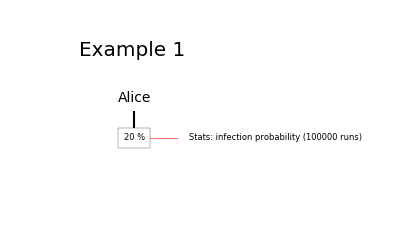

  2.845499 seconds (14.17 M allocations: 676.696 MiB, 7.25% gc time)


In [43]:
function example1()::Model   
    println("\nExample 1: notePerson")
    m = Model("Example 1")
    notePerson!(m, "Alice", infectedProbability=0.200)
    noteStats!(m)
    return m
end

m = example1()
@time simulation(m, 0, 100000)
# @time simulation(example1(), 0, 100000)
# correct answer is
#     Prob(Alice infected) = 0.200

simPlot(m)

## Example 2: A Two-Day Example

This is identical to example 1, with the addition of a NewDay, which
causes a transition to day 2 in the simulation.

Example 2: notePerson and noteNewDay
Starting simulation with simulationSeed 0 and 100000 runs
  Stats number 1
        Alice:  20046/100000 ≈ 0.200
  Stats number 2
        Alice:  18647/100000 ≈ 0.186


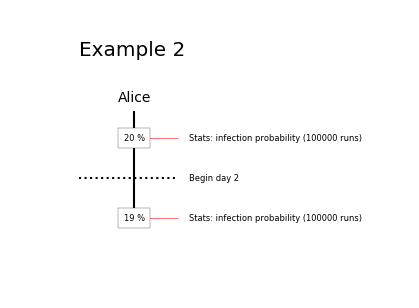


Done.  0.516121 seconds (3.31 M allocations: 73.573 MiB, 2.31% gc time)


In [44]:
function example2()::Model   
    println("Example 2: notePerson and noteNewDay")
    m = Model("Example 2")
    notePerson!(m, "Alice", infectedProbability=0.200)
    noteStats!(m)
    # day 2
    noteNewDay!(m)
    noteStats!(m)
    return m
end

# @time simulation(example2(), 0, 100000)
m = example2()
@time simulation(m, 0, 100000)
# correct answer for end of day 2 is 
#     Prob(Alice infected) = 0.20 * 13/14 = 0.1857 
# since Alice recovers when entering day 2 with probability 1/14.

simPlot(m)

## Example 3: One person, one day, and one perfect test

In this example, Alice initially appears with an infection probability
of 0.02.  But she is immediately tested, and the test result is "true" (infected).
So the probability of her being infected, conditioned on this test result, is
1.000.

Example 3: notePerson and noteTest (with perfect test)
Starting simulation with simulationSeed 0 and 100000 runs
  Stats number 1
        Alice:  2021/100000 ≈ 0.020
  Stats number 2
        Alice:  2021/2021 ≈ 1.000


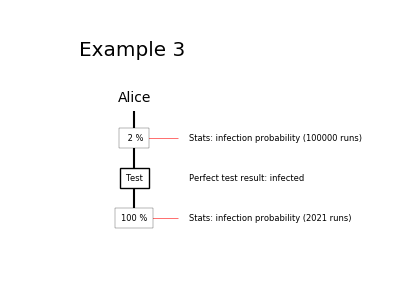


Done.  0.344656 seconds (2.03 M allocations: 48.102 MiB, 2.46% gc time)


In [45]:
function example3()::Model   
    println("Example 3: notePerson and noteTest (with perfect test)")
    m = Model("Example 3")
    notePerson!(m, "Alice", infectedProbability=0.020)
    noteStats!(m)
    noteTest!(m, "Alice", PerfectTest, true)   # perfect test returned true here
    noteStats!(m)
    return m
end

m = example3()
@time simulation(m, 0, 100000)
# correct answer for end of day 1 is
#     Prob(Alice infected) = 1.000

simPlot(m)

## Example 4: One person, one day, and one imperfect test

This is the same as example 3, except that the test is now *imperfect*, with
a probability of detection (correctly reporting) an infected individual of only
ninety-five percent, and a probability of a false alarm (incorrectly reporting an uninfected
individual as infected) of five percent.  Alice appears on the scene initially with
an infection probability of 0.020.  She is then tested by an imperfect test, which has
a 0.05 false negative rate and a 0.05 false positive rate.  The test returns "true" (infected).
The chance that Alice is actually infected is only 0.279, due to false positives.
(See the next example for the improvement when one has a repeated PCR test.)  Many are surprised
to see a positive test result from a test that is "95% accurate" have a post-test posterior
probability of only 28%.

Example 4: notePerson and noteTest (with imperfect PCR test)
Starting simulation with simulationSeed 0 and 100000 runs
  Stats number 1
        Alice:  2021/100000 ≈ 0.020
  Stats number 2
        Alice:  1917/6835 ≈ 0.280


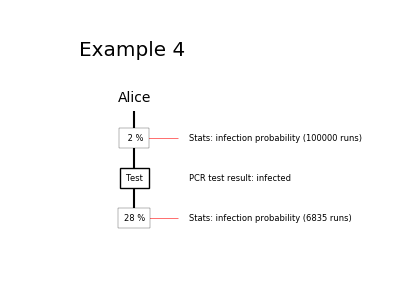


Done.  0.363067 seconds (2.09 M allocations: 49.344 MiB, 2.13% gc time)


In [46]:
function example4()::Model   
    println("Example 4: notePerson and noteTest (with imperfect PCR test)")
    m = Model("Example 4")
    notePerson!(m, "Alice", infectedProbability=0.020)
    noteStats!(m)
    noteTest!(m, "Alice", PCRTest, true)   # PCR is imperfect test
    noteStats!(m)
    return m
end

m = example4()
@time simulation(m, 0, 100000)
# corect result here is
#     Prob(Alice infected | TestResult simulated as reported) 
#     = 0.020 * 0.95 / (0.020 * 0.95 + 0.980 * 0.05) = 0.279

simPlot(m)

## Example 5: One person, one day, and a repeated imperfect test

This is the same as example 4, except that the imperfect test is repeated for a second time.
The second test also returns "true" (infected). 
The estimated chance that Alice is actually infected rises from 0.279 to 0.884.

Example 5: notePerson and two noteTests (two independent imperfect PCR tests)
Starting simulation with simulationSeed 0 and 100000 runs
  Stats number 1
        Alice:  2021/100000 ≈ 0.020
  Stats number 2
        Alice:  1917/6835 ≈ 0.280
  Stats number 3
        Alice:  1831/2090 ≈ 0.876


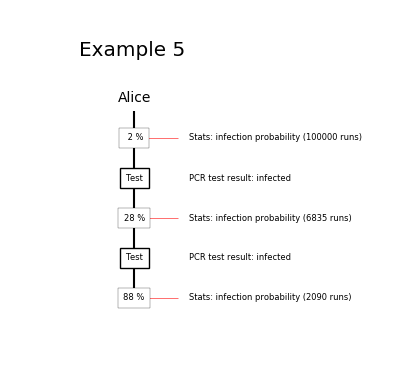


Done.  0.388298 seconds (2.15 M allocations: 50.906 MiB, 3.20% gc time)


In [47]:
function example5()::Model   
    println("Example 5: notePerson and two noteTests (two independent imperfect PCR tests)")
    m = Model("Example 5")
    notePerson!(m, "Alice", infectedProbability=0.020)
    noteStats!(m)
    noteTest!(m, "Alice", PCRTest, true)   # PCR is imperfect test
    noteStats!(m)
    noteTest!(m, "Alice", PCRTest, true)   # second independent PCR test
    noteStats!(m)
    return m
end

m = example5()
@time simulation(m, 0, 100000)
# corect result here is roughly
#     Prob(Alice infected | TestResult simulated as reported) 
#     = 0.020 * 0.95^2 / (0.020 * 0.95^2 + 0.980 * 0.05^2) = 0.884

simPlot(m)

## Example 6: One person, one SymptomOnset

Same as example 4, except replacing a test with symptom onset.  The result is similar, except that the number of consistent runs is greatly reduced, as symptom onset can happen only on day 5 of infection in our model, if the person is symptomatic.

Example 6: notePerson and one noteSymptomOnset
Starting simulation with simulationSeed 0 and 1000000 runs
  Stats number 1
        Alice:  400004/1000000 ≈ 0.400
  Stats number 2
        Alice:  17358/17358 ≈ 1.000


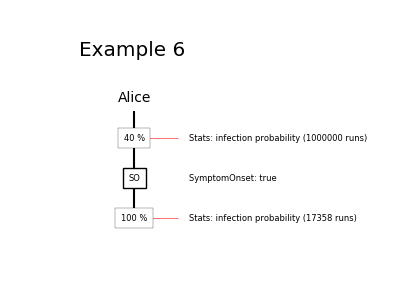


Done.  3.683867 seconds (20.83 M allocations: 487.386 MiB, 1.51% gc time)


In [48]:
function example6()::Model
    println("Example 6: notePerson and one noteSymptomOnset")
    m = Model("Example 6")
    notePerson!(m, "Alice", infectedProbability=0.400)
    noteStats!(m)
    noteSymptomOnset!(m, "Alice", true)
    noteStats!(m)
    return m
end

m = example6()
@time simulation(m, 0, 1000000)
# 1000000 runs * 0.400 infection rate = 400000 infected
#  400000 infected * 0.600 symptomatic rate = 240000 symptomatic infected
#  240000 symptomatic infected / 14 infected states = 17143 people with symptom onset

simPlot(m)

## Example 7: Two person, one day, close contact

This example has two people, Alice and Bob, who appear on day 1 with
initial probabilities of being infected of twenty and thirty percent, respectively.
They have a close contact for two hours.

Example 7: notePerson and noteContact
Starting simulation with simulationSeed 2 and 1000000 runs
  Stats number 1
        Alice:  200385/1000000 ≈ 0.200
        Bob:  298887/1000000 ≈ 0.299
  Stats number 2
        Alice:  271633/1000000 ≈ 0.272
        Bob:  340775/1000000 ≈ 0.341


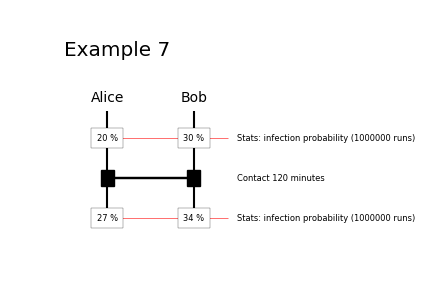


Done.  6.909286 seconds (55.01 M allocations: 1.282 GiB, 1.95% gc time)


In [49]:
function example7()::Model   
    println("Example 7: notePerson and noteContact")
    m = Model("Example 7")
    notePerson!(m, "Alice", infectedProbability=0.200, maskedProbability=0.0)
    notePerson!(m, "Bob", infectedProbability=0.300, maskedProbability=0.0)
    noteStats!(m)
    noteContact!(m, ["Alice", "Bob"], minutes=120)
    noteStats!(m)
    return m
end

m = example7()
@time simulation(m, 2, 1000000)
# As transmission has probability 1-(1-0.05)^8 = 0.336, 
# the correct answer is (for uniform infectiousness, which isn't quite accurate)
#   Prob(Alice infected) = 0.200 + 0.336 * 0.800 * 0.300 = 0.281
#   Prob(Bob infected) = 0.300 + 0.336 * 0.200 * 0.700 = 0.347

simPlot(m)

## Example 8: Twelve person (ten unknown), one day, close contact

This example has two known people, Alice and Bob, who appear on day 1 with initial infection probabilities of twenty and thirty percent, respectively. They have a close contact for two hours, as in Example 7.  This close contact now includes ten other people, who are anonymous, and thus assume default parameter settings.  (Maybe Alice and Bob were on a bus ride with ten people they didn't know.)

We can see that the final infection probabilities for Alice and Bob increase, compared to Example 7, as one would expect. 

Example 8: notePerson and noteContact (with ten unknown parties)
Starting simulation with simulationSeed 0 and 1000000 runs
  Stats number 1
        Alice:  200019/1000000 ≈ 0.200
        Bob:  299737/1000000 ≈ 0.300
  Stats number 2
        Alice:  312246/1000000 ≈ 0.312
        Bob:  381915/1000000 ≈ 0.382


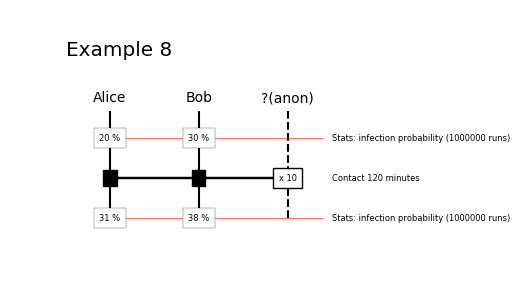


Done.  7.230288 seconds (55.00 M allocations: 1.282 GiB, 1.94% gc time)


In [50]:
function example8()::Model   
    println("Example 8: notePerson and noteContact (with ten unknown parties)")
    m = Model("Example 8")
    notePerson!(m, "Alice", infectedProbability=0.200, maskedProbability=0.0)
    notePerson!(m, "Bob", infectedProbability=0.300, maskedProbability=0.0)
    noteStats!(m)
    noteContact!(m, ["Alice", "Bob"], minutes=120, anonymousNumber=10) 
    noteStats!(m)
    return m
end

m = example8()
@time simulation(m, 0, 1000000)

simPlot(m)

## Example 9: Three named people, four anonymous people, two tests, and a NewDay

(Explained above; this is the introductory example.)

In [51]:
function example9()::Model
    m = Model("Example 9")
    # day 1
    notePerson!(m, "me", infectedProbability=0.00, maskedProbability=0.500)
    notePerson!(m, "Jack", infectedProbability=0.05, maskedProbability=0.000)
    notePerson!(m, "Jill", infectedProbability=0.10, maskedProbability=1.00)
    noteStats!(m)
    noteContact!(m, ["me", "Jack"], minutes=120)
    noteContact!(m, ["me", "Jill"], anonymousNumber=4, minutes=60)
    # day 2
    noteNewDay!(m)
    noteStats!(m)
    noteTest!(m, "Jack", PCRTest, true)
    noteTest!(m, "Jill", PCRTest, false)
    noteStats!(m)
    return m
end    

example9 (generic function with 1 method)

Starting simulation with simulationSeed 1 and 100000 runs
  Stats number 1
        me:  0/100000 ≈ 0.000
        Jack:  5057/100000 ≈ 0.051
        Jill:  10149/100000 ≈ 0.101
  Stats number 2
        me:  1407/100000 ≈ 0.014
        Jack:  4701/100000 ≈ 0.047
        Jill:  9499/100000 ≈ 0.095
  Stats number 3
        me:  675/8074 ≈ 0.084
        Jack:  3916/8074 ≈ 0.485
        Jill:  52/8074 ≈ 0.006


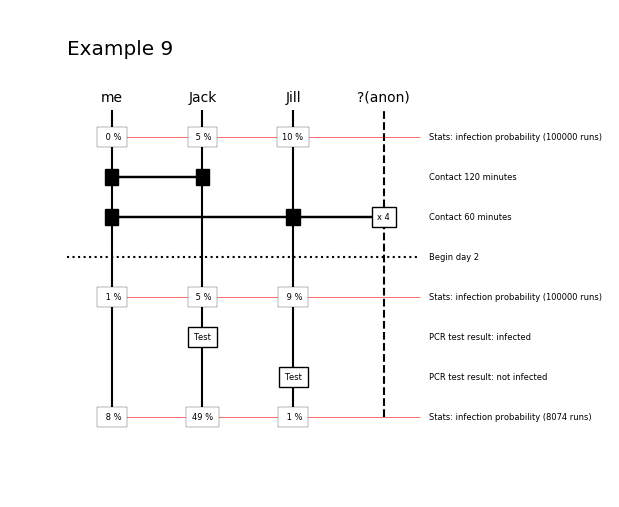


Done.  1.362576 seconds (9.49 M allocations: 231.043 MiB, 2.31% gc time)


In [52]:
m = example9()
@time simulation(m, 1, 100000)

simPlot(m, save="example9")

## Example 10: a complex thirteen-person example

This example has three known people: Alice, Bob, and Charles, and ten
anonymous people.  The example proceeds for three days, and has
four contact events.

Starting simulation with simulationSeed 1 and 100000 runs
  Stats number 1
        Alice:  19954/100000 ≈ 0.200
        Bob:  30140/100000 ≈ 0.301
        Charles:  39957/100000 ≈ 0.400
  Stats number 2
        Alice:  21064/100000 ≈ 0.211
        Bob:  30772/100000 ≈ 0.308
        Charles:  39957/100000 ≈ 0.400
  Stats number 3
        Alice:  19611/100000 ≈ 0.196
        Bob:  28643/100000 ≈ 0.286
        Charles:  37139/100000 ≈ 0.371
  Stats number 4
        Alice:  21055/100000 ≈ 0.211
        Bob:  28643/100000 ≈ 0.286
        Charles:  37737/100000 ≈ 0.377
  Stats number 5
        Alice:  19626/100000 ≈ 0.196
        Bob:  26483/100000 ≈ 0.265
        Charles:  34840/100000 ≈ 0.348
  Stats number 6
        Alice:  9884/36348 ≈ 0.272
        Bob:  12215/36348 ≈ 0.336
        Charles:  33224/36348 ≈ 0.914


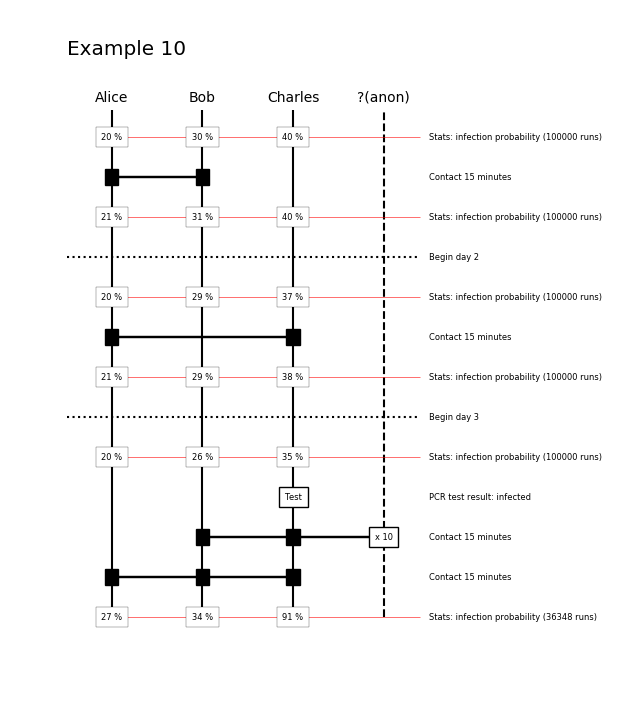


Done.  2.483053 seconds (19.90 M allocations: 469.296 MiB, 2.82% gc time)


In [53]:
function example10()::Model 
    m = Model("Example 10")
    # day 1
    notePerson!(m, "Alice", infectedProbability=0.200, maskedProbability=0.00)
    notePerson!(m, "Bob", infectedProbability=0.300, maskedProbability=0.00)
    notePerson!(m, "Charles", infectedProbability=0.400, maskedProbability=0.00)
    noteStats!(m)
    noteContact!(m, ["Alice", "Bob"], minutes=15)
    noteStats!(m)
    # day 2
    noteNewDay!(m)
    noteStats!(m)
    noteContact!(m, ["Alice", "Charles"], minutes=15)
    noteStats!(m)
    # day 3
    noteNewDay!(m)
    noteStats!(m)
    noteTest!(m, "Charles", PCRTest, true)
    noteContact!(m, ["Bob", "Charles"], minutes=15, anonymousNumber=10)
    noteContact!(m, ["Alice", "Bob", "Charles"], minutes=15)
    noteStats!(m)
    return m
end

m = example10()
@time simulation(m, 1, 100000)

simPlot(m)

## Example 11: Can a PCR positive test be cleared by a subsequent negative test?

Here is an example motivated by this article:
(https://medical.mit.edu/covid-19-updates/2020/11/pcr-test-result).

The short answer is "yes".  That is to say, you can combine the results of more than one test to get a final probability of infection.  In our case, where a PCR test has equal values for "miss probability" ($1-P_{DET}$) and "false alarm probability" ($P_{FA}$) then 
one negative test exactly cancels one positive test, so you might want *two* negative tests to conclude an overall "negative" result.

Starting simulation with simulationSeed 1 and 100000 runs
  Stats number 1
        me:  1948/100000 ≈ 0.019
  Stats number 2
        me:  1857/6868 ≈ 0.270
  Stats number 3
        me:  83/4801 ≈ 0.017


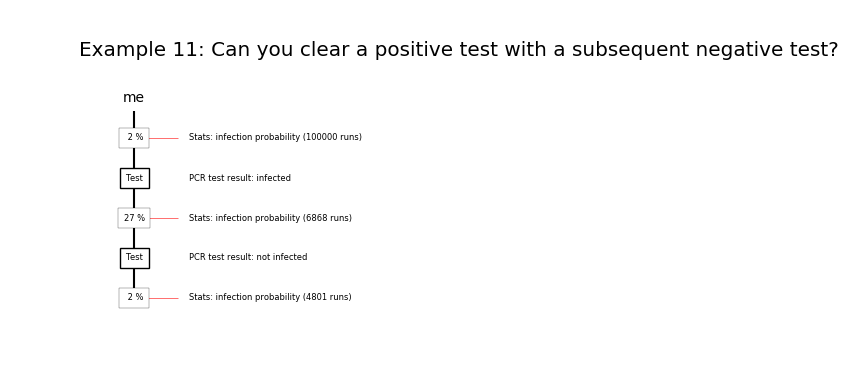


Done.  0.379335 seconds (2.19 M allocations: 51.705 MiB, 1.97% gc time)


In [54]:
function example11()
    m = Model("Example 11: Can you clear a positive test with a subsequent negative test?")
    notePerson!(m, "me", infectedProbability=0.02)
    noteStats!(m)
    noteTest!(m, "me", PCRTest, true)
    noteStats!(m)
    noteTest!(m, "me", PCRTest, false)
    noteStats!(m)
    return m
end

m = example11()
@time simulation(m, 1, 100000)

simPlot(m)


# Notes

Each simulation run could have different parameters, not just a different
simulation seed (see SafeBlues video).



# Related Work

[SafeBlues](https://safeblues.org/)

[COVID-19 Indoor Safety Guideline](http://www.mit.edu/~bazant/COVID-19/)

Simulated Automatic Exposure
Notification (SimAEN):
Exploring the Effects of
Interventions on the Spread of
COVID, by 
Ted Londner, Jonathan Saunders, Dieter W. Schuldt, Dr. Bill Streilein (Lincoln Laboratory) -- to appear.


# Acknowledgments

Ronald L. Rivest has received support from
the Center for Science of Information (CSoI), an
NSF Science and Technology Center, under grant
agreement CCF-0939370.  

He would like to thank his many colleagues,
on the [PACT](http://pact.mit.edu)
project and elsewhere, for teaching
him about covid-19.  

The code here is freely usable by others (under the
[MIT License](https://opensource.org/licenses/MIT)).

Thanks to Alan Edelman and Valentin Churavy for suggesting ways
to improve the code efficiency.